In [27]:
import pandas as pd
import json
import numpy as np
from nltk.app.nemo_app import colors
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
with open("../data/hard_tracks_dataset/annotations/hard_tracks_dataset_coco_val.json", 'r') as f:
    annotations = json.load(f)

with open("../results/teta_results_5_frame_val_htd_val/tao_track.json", 'r') as f:
    predictions = json.load(f)


print("Annotations keys: ", annotations.keys())
for key in annotations.keys():
    print(key, ": ", annotations[key][0]) if type(annotations[key]) == list else print(key, ": ", annotations[key])

print("Prediction: ", predictions[0])

Annotations keys:  dict_keys(['videos', 'tracks', 'images', 'annotations', 'categories'])
videos :  {'id': 2, 'width': 640, 'height': 1138, 'neg_category_ids': [482, 422, 407, 557, 579], 'not_exhaustive_category_ids': [], 'name': 'TAO/YFCC100M/v_2dbe9f59c615e1641d42829f94607281', 'metadata': {'dataset': 'YFCC100M', 'user_id': '96124520@N03', 'username': 'Scarr084'}, 'frame_range': 30}
tracks :  {'id': 3, 'category_id': 2, 'video_id': 2}
images :  {'id': 41, 'video': 'TAO/YFCC100M/v_2dbe9f59c615e1641d42829f94607281', '_scale_task_id': '5de7fcf54a57c800262c3995', 'width': 640, 'height': 1138, 'file_name': 'TAO/YFCC100M/v_2dbe9f59c615e1641d42829f94607281/frame0061.jpg', 'frame_index': 60, 'license': 0, 'video_id': 2, 'frame_id': 0, 'neg_category_ids': [482, 422, 407, 557, 579], 'not_exhaustive_category_ids': []}
annotations :  {'segmentation': [[145, 841, 234, 841, 234, 942, 145, 942]], 'bbox': [145.0, 841.0, 89.0, 101.0], 'area': 8989, 'iscrowd': 0, 'id': 46, 'image_id': 41, 'category_id

In [29]:

# Create dictionaries for faster access
video_dict = {video["id"]: video for video in annotations["videos"]}
track_dict = {track["id"]: track for track in annotations["tracks"]}

image_dict = {image["id"]: image for image in annotations["images"]}
image_by_video = dict()
for image in annotations["images"]:
    if image["video_id"] not in image_by_video:
        image_by_video[image["video_id"]] = []
    image_by_video[image["video_id"]].append(image)

annotations_dict = {annotation["id"]: annotation for annotation in annotations["annotations"]}
annotations_by_track = dict()
annotations_by_image = dict()
for annotation in annotations["annotations"]:
    if annotation["track_id"] not in annotations_by_track:
        annotations_by_track[annotation["track_id"]] = []
    annotations_by_track[annotation["track_id"]].append(annotation)

    if annotation["image_id"] not in annotations_by_image:
        annotations_by_image[annotation["image_id"]] = []
    annotations_by_image[annotation["image_id"]].append(annotation)

# Create dictionaries for predictions for faster access
predictions_by_video = dict()
predictions_by_image = dict()
for prediction in predictions:
    if prediction["video_id"] not in predictions_by_video:
        predictions_by_video[prediction["video_id"]] = []
    predictions_by_video[prediction["video_id"]].append(prediction)

    if prediction["image_id"] not in predictions_by_image:
        predictions_by_image[prediction["image_id"]] = []
    predictions_by_image[prediction["image_id"]].append(prediction)

In [30]:
def calculate_iou(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    # Calculate the (x, y) coordinates of the intersection rectangle
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)

    # Check if there is an intersection
    if x_right <= x_left or y_bottom <= y_top:
        return 0.0

    # Calculate the area of intersection
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate the area of both bounding boxes
    bbox1_area = w1 * h1
    bbox2_area = w2 * h2

    # Calculate the IoU
    iou = intersection_area / float(bbox1_area + bbox2_area - intersection_area)

    return iou

In [31]:

IoU_threshold = 0.5
scale_change_threshold = 0.5
scale_change_n = 1
memory_frames = 10
position_change_threshold = 1/25

resutls_dict = dict()

# for venn diagram
id_switch_list_for_venn = []

for track_id in track_dict.keys():

    track = track_dict[track_id]
    video = video_dict[track["video_id"]] # For metadata
    images = image_by_video[video["id"]]
    annotations = annotations_by_track.get(track_id, [])

    if len(annotations) == 0:
        print("No annotations for track: ", track_id)
        continue

    track_annotations_by_image = {annotation["image_id"]: annotation for annotation in annotations}



    # Init metrics ------------------------------------------------------------------

    # Overall id switch
    id_switch = 0                                   # Total number of id switches
    possible_assosiations = len(annotations) - 1    # Number of possible assosiations with annotations
    id_switch_ids = []                              # List of ids the track got assigned to

    # Id switches after absence
    ## Overall
    is_switch_absence = 0                   # Number of id switches caused by absence of the object in the previous frames (occlusion or detection failure)
    success_after_absence = 0               # Number of times the object was correctly assigned after absence
    possible_assosiations_absence = 0       # Number of possible assosiations with annotations after absence
    id_switch_absence_lengths = []          # Lengths of absence which caused id switch
    success_after_absence_lengths = []      # Lengths of absence with success after absence

    ## After occlusion
    id_switch_occ = 0                   # Id switches after by occlusion
    success_after_occ = 0               # Number of times the object was correctly assigned after occlusion
    possible_assosiations_occ = 0       # Number of possible assosiations with annotations after occlusion
    id_switch_occ_lengths = []          # Lengths of occlusion which caused id switch
    success_after_occ_lengths = []      # Lengths of occlusion with success after occlusion

    ## After detection failure
    id_switch_det = 0                   # Id switches caused by detection failure
    success_after_det = 0               # Number of times the object was correctly assigned after detection failure
    possible_assosiations_det = 0       # Number of possible assosiations with annotations after detection failure
    id_switch_det_lengths = []          # Lengths of detection failure which caused id switch
    success_after_det_lengths = []      # Lengths of detection failure with success after detection failure

    ## After memory timespan
    id_switch_mem = 0                   # Id switches caused by lacking memory

    # Id switches between frames
    ## Overall (appearance change)
    id_switch_inter_frames = 0                  # Number of id switches caused by the object being detected in the last and current frame but with different id
    possible_assosiations_inter_frames = 0      # Number of possible assosiations with annotations between frames (where the object was present in the last and current frame)

    ## After position change
    id_switch_after_pos = 0                     # Id switches caused by position change
    possible_assosiations_pos_changes = 0       # Number of possible assosiations with annotations after position change

    ## After scale change
    id_switch_after_scale = 0                   # Id switches caused by scale change
    possible_assosiations_scale_changes = 0     # Number of possible assosiations with annotations after scale change


    # Others
    recoveries = 0      # Number of times the initial id is recovered after one or multiple id switches
    id_switch_rec_lengths = [] # Number of id switches until recovering the initial id
    detection_failures = 0

    id_switch_too_low_iou = 0
    is_switch_ping_pong = 0






    # Other variables
    first_appearance = False
    initial_instance_assignment = None
    current_instance_assignment = None

    absence_length = 0
    occlusion_length = 0
    detection_failure_length = 0

    switches_until_recovery = 0
    last_n_scales = []
    previous_position = None
    current_id_switch = 0


    for image in images:

        image_id = image["id"]
        annotation = track_annotations_by_image.get(image_id, None)
        predictions = predictions_by_image.get(image_id, [])

        # Skip until the first appearance
        if annotation is None and not first_appearance: continue
        first_appearance = True

        # Check if one of the predictions matches the annotation
        if annotation is not None:

            # Find matching prediction with highest IoU
            matching_prediction = None
            matching_prediction_iou = 0

            matching_pred_based_on_previous_id = None
            for prediction in predictions:
                # if prediction["category_id"] == annotation["category_id"]: TODO: MASA matches everything with everything - check if this is needed
                iou = calculate_iou(annotation["bbox"], prediction["bbox"])
                if iou > IoU_threshold and iou > matching_prediction_iou:
                    matching_prediction = prediction
                    matching_prediction_iou = iou

                # check if a prediction matches the previous instance id
                if current_instance_assignment is not None and prediction["track_id"] == current_instance_assignment:
                    matching_pred_based_on_previous_id = prediction


            # Check scale change
            is_scale_change = False
            current_scale = annotation['bbox'][2] * annotation['bbox'][3]
            last_scale = last_n_scales[-1] if len(last_n_scales) > 0 else None
            if len(last_n_scales) < 1: last_n_scales.append(current_scale)
            else:
                if abs(current_scale - last_scale) / last_scale > scale_change_threshold:
                    is_scale_change = True

                if len(last_n_scales) < scale_change_n: last_n_scales.append(current_scale)
                else: last_n_scales = last_n_scales[1:] + [current_scale]

            # Check position change
            is_position_change = False
            current_position = (annotation['bbox'][0] + annotation['bbox'][2] / 2, annotation['bbox'][1] + annotation['bbox'][3] / 2)
            if previous_position is None: previous_position = current_position
            else:
                img_width = image['width']
                distance = np.sqrt((current_position[0] - previous_position[0]) ** 2 + (current_position[1] - previous_position[1]) ** 2)
                distance_norm = distance / img_width

                if distance_norm > position_change_threshold:
                    is_position_change = True
                previous_position = current_position

            if matching_prediction is not None:
                # Check if id switch
                if initial_instance_assignment is None: # First instance assignment
                    initial_instance_assignment = matching_prediction["track_id"]
                    current_instance_assignment = matching_prediction["track_id"]
                    id_switch_ids.append(matching_prediction["track_id"])

                    # can happen that the object was not detected in the first frames
                    if absence_length > 0:
                        id_switch += 1
                        is_switch_absence += 1
                        id_switch_absence_lengths.append(absence_length)

                        if occlusion_length > 0:
                            id_switch_occ += 1
                            id_switch_occ_lengths.append(occlusion_length)

                        if detection_failure_length > 0:
                            id_switch_det += 1
                            id_switch_det_lengths.append(detection_failure_length)

                elif current_instance_assignment != matching_prediction["track_id"]: # Id switch
                    id_switch += 1
                    id_switch_ids.append(matching_prediction["track_id"])

                    # for venn diagram
                    curr_id_switch = {
                        "id": len(id_switch_list_for_venn),
                        "is_switch_absence": False,
                        "is_switch_inter_frames": False,
                        "is_switch_after_pos": False,
                        "is_switch_after_scale": False,
                        "is_switch_occ": False,
                        "is_switch_det": False,
                        "is_switch_too_low_iou": False,
                        "is_switch_ping_pong": False
                    }

                    # Absence of the object in the previous frames
                    if absence_length > 0:
                        is_switch_absence += 1
                        id_switch_absence_lengths.append(absence_length)
                        curr_id_switch["is_switch_absence"] = True

                        # Lacking memory
                        if absence_length > memory_frames:
                            id_switch_mem += 1
                            curr_id_switch["is_switch_mem"] = True

                        # Object got re-detected after occlusion
                        if occlusion_length > 0:
                            id_switch_occ += 1
                            id_switch_occ_lengths.append(occlusion_length)
                            curr_id_switch["is_switch_occ"] = True

                        # Object got re-detected after it was not detected for some time
                        if detection_failure_length > 0:
                            id_switch_det += 1
                            id_switch_det_lengths.append(detection_failure_length)
                            curr_id_switch["is_switch_det"] = True
                    else:
                        id_switch_inter_frames += 1
                        curr_id_switch["is_switch_inter_frames"] = True

                    # Recovery
                    if matching_prediction["track_id"] == initial_instance_assignment:
                        recoveries += 1
                        id_switch_rec_lengths.append(switches_until_recovery)
                        switches_until_recovery = 0
                    else:
                        switches_until_recovery += 1

                    # Check scale change
                    if is_scale_change:
                        id_switch_after_scale += 1
                        curr_id_switch["is_switch_after_scale"] = True

                    # Check position change
                    if is_position_change:
                        id_switch_after_pos += 1
                        curr_id_switch["is_switch_after_pos"] = True


                    # Check if the id switch was caused by too low IoU
                    # match_but_no_best = matching_prediction is None and matching_pred_based_on_previous_id is not None
                    match_but_not_best = matching_prediction is not None and matching_pred_based_on_previous_id is not None and matching_pred_based_on_previous_id != matching_prediction["track_id"]
                    if match_but_not_best:
                        id_switch_too_low_iou += 1
                        curr_id_switch["is_switch_too_low_iou"] = True

                    # Check if the id switch was caused by ping pong
                    if len(id_switch_ids) > 3 and id_switch_ids[-1] == id_switch_ids[-3] and id_switch_ids[-2] == id_switch_ids[-4]:
                        is_switch_ping_pong += 1
                        curr_id_switch["is_switch_ping_pong"] = True


                    id_switch_list_for_venn.append(curr_id_switch)
                    current_instance_assignment = matching_prediction["track_id"]

                elif matching_prediction["track_id"] == current_instance_assignment: # correctly assigned

                    if absence_length > 0:
                        success_after_absence += 1
                        success_after_absence_lengths.append(absence_length)

                        if occlusion_length > 0:
                            success_after_occ += 1
                            success_after_occ_lengths.append(occlusion_length)

                        if detection_failure_length > 0:
                            success_after_det += 1
                            success_after_det_lengths.append(detection_failure_length)

                    current_instance_assignment = matching_prediction["track_id"]
                else:
                    raise Exception("This should not happen")


                # Check if the object was previously absent. If so, the model has a chance to re-assign the correct id
                if absence_length > 0:
                    possible_assosiations_absence += 1

                    if occlusion_length > 0:
                        possible_assosiations_occ += 1
                    if detection_failure_length > 0:
                        possible_assosiations_det += 1
                else:
                    possible_assosiations_inter_frames += 1

                if is_scale_change:
                    possible_assosiations_scale_changes += 1

                if is_position_change:
                    possible_assosiations_pos_changes += 1



                # Object was detected so reset occlusion and detection failure
                occlusion_length = 0
                detection_failure_length = 0
                absence_length = 0

            else:
                # Detection failure
                detection_failure_length += 1
                detection_failures += 1
                absence_length += 1
        else:
            # Occlusion
            occlusion_length += 1
            absence_length += 1


    # Save metrics
    resutls_dict[track_id] = {
        "track_id": track_id,
        "video_id": video["id"],
        "video_name": video["name"],
        "video_length": len(images),

        "id_switch": id_switch,
        "possible_assosiations": possible_assosiations,
        "id_switch_ids": id_switch_ids,

        "id_switch_absence": is_switch_absence,
        "success_after_absence": success_after_absence,
        "possible_assosiations_absence": possible_assosiations_absence,
        "id_switch_absence_lengths": id_switch_absence_lengths,
        "success_after_absence_lengths": success_after_absence_lengths,

        "id_switch_occ": id_switch_occ,
        "success_after_occ": success_after_occ,
        "possible_assosiations_occ": possible_assosiations_occ,
        "id_switch_occ_lengths": id_switch_occ_lengths,
        "success_after_occ_lengths": success_after_occ_lengths,

        "id_switch_det": id_switch_det,
        "success_after_det": success_after_det,
        "possible_assosiations_det": possible_assosiations_det,
        "id_switch_det_lengths": id_switch_det_lengths,
        "success_after_det_lengths": success_after_det_lengths,

        "id_switch_mem": id_switch_mem,

        "id_switch_too_low_iou": id_switch_too_low_iou,

        "id_switch_ping_pong": is_switch_ping_pong,

        "id_switch_inter_frames": id_switch_inter_frames,
        "possible_assosiations_inter_frames": possible_assosiations_inter_frames,

        "id_switch_after_pos": id_switch_after_pos,
        "possible_assosiations_pos_changes": possible_assosiations_pos_changes,

        "id_switch_after_scale": id_switch_after_scale,
        "possible_assosiations_scale_changes": possible_assosiations_scale_changes,

        "recoveries": recoveries,
        "id_switch_rec_lengths": id_switch_rec_lengths,
        "detection_failures": detection_failures,
    }

# Create dataframe
track_with_failures = pd.DataFrame(resutls_dict).T

# create dataframe for venn diagram
venn_df = pd.DataFrame(id_switch_list_for_venn)

In [32]:
track_with_failures

,track_id,video_id,video_name,video_length,id_switch,possible_assosiations,id_switch_ids,id_switch_absence,success_after_absence,possible_assosiations_absence,...,id_switch_ping_pong,id_switch_inter_frames,possible_assosiations_inter_frames,id_switch_after_pos,possible_assosiations_pos_changes,id_switch_after_scale,possible_assosiations_scale_changes,recoveries,id_switch_rec_lengths,detection_failures
3,3,2,TAO/YFCC100M/v_2dbe9f59c615e1641d42829f94607281,40,1,22,"[0, 26]",1,5,6,...,0,0,10,1,13,1,5,0,[],7
4,4,3,TAO/YFCC100M/v_bf3cad1558afc304c4d28a699c16de7,40,3,21,"[68, 127, 131]",3,0,3,...,0,0,1,1,2,1,1,0,[],18
5,5,3,TAO/YFCC100M/v_bf3cad1558afc304c4d28a699c16de7,40,4,10,"[73, 120, 121, 120]",3,0,3,...,0,1,5,1,3,2,3,0,[],3
21,21,12,TAO/HACS/Camel_ride_v_FOlkdk4hiKY_scene_0_0-1071,36,2,5,"[161, 465, 833]",1,0,1,...,0,1,5,2,5,0,0,0,[],0
23,23,14,TAO/HACS/Shaving_v_8AUE0UANshQ_scene_0_83-2198,40,9,28,"[959, 958, 959, 958, 959, 969, 959, 957, 959, ...",5,1,6,...,2,4,19,9,18,3,3,4,"[1, 1, 1, 1]",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,1378,463,BFT/Ci2001,212,6,158,"[770350, 770357, 770373, 770375, 770333, 770400]",5,6,11,...,0,1,113,1,1,3,4,0,[],35
1379,1379,463,BFT/Ci2001,212,2,122,"[770341, 770392, 770400]",1,1,2,...,0,1,116,0,0,0,1,0,[],5
1382,1382,466,BFT/Pa1003,63,10,47,"[770447, 770451, 770463, 770460, 770490, 77050...",5,7,12,...,0,5,17,1,1,4,5,0,[],19
1383,1383,467,BFT/Su2005,128,37,117,"[770715, 770725, 770742, 770725, 770742, 77073...",11,2,13,...,1,26,56,0,0,0,0,0,[],49


In [33]:
assert track_with_failures[track_with_failures["id_switch_occ"] + track_with_failures["success_after_occ"] != track_with_failures["possible_assosiations_occ"]].shape[0] == 0
assert track_with_failures[track_with_failures["id_switch_det"] + track_with_failures["success_after_det"] != track_with_failures["possible_assosiations_det"]].shape[0] == 0
assert track_with_failures[track_with_failures["id_switch_absence"] + track_with_failures["success_after_absence"] != track_with_failures["possible_assosiations_absence"]].shape[0] == 0

# Analysis

## Overview

Number of tracks with id switches: 625 / 679 --- percentage: 92.04712812960236%
Number of id switches:  6706


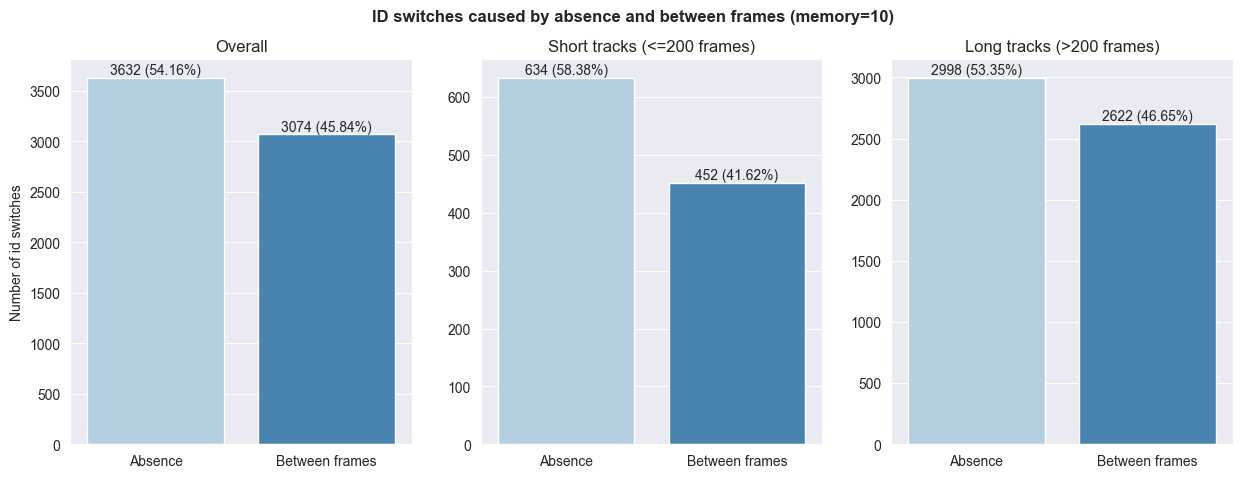

In [34]:
num_tracks_with_id_switches = track_with_failures[track_with_failures["id_switch"] > 0].shape[0]
print(f"Number of tracks with id switches: {num_tracks_with_id_switches} / {track_with_failures.shape[0]} --- percentage: {num_tracks_with_id_switches / track_with_failures.shape[0] * 100}%")

print("Number of id switches: ", track_with_failures["id_switch"].sum())

# barchart with 2 bars (switches by absence, switches by inter frames) with number of id switches over each bar
num_switches_absence = track_with_failures["id_switch_absence"].sum()
num_switches_inter_frames = track_with_failures["id_switch_inter_frames"].sum()

short_track_with_failures = track_with_failures[track_with_failures["video_length"] <= 200]
num_switches_absence_short = short_track_with_failures["id_switch_absence"].sum()
num_switches_inter_frames_short = short_track_with_failures["id_switch_inter_frames"].sum()

long_track_with_failures = track_with_failures[track_with_failures["video_length"] > 200]
num_switches_absence_long = long_track_with_failures["id_switch_absence"].sum()
num_switches_inter_frames_long = long_track_with_failures["id_switch_inter_frames"].sum()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(x=["Absence", "Between frames"], y=[num_switches_absence, num_switches_inter_frames], ax=ax[0], palette="Blues")
ax[0].set_ylabel("Number of id switches")
ax[0].set_title("Overall")
for i, v in enumerate([num_switches_absence, num_switches_inter_frames]):
    ax[0].text(i, v + 1, f"{v} ({v / track_with_failures['id_switch'].sum() * 100:.2f}%)", ha='center', va='bottom')

sns.barplot(x=["Absence", "Between frames"], y=[num_switches_absence_short, num_switches_inter_frames_short], ax=ax[1], palette="Blues")
ax[1].set_title("Short tracks (<=200 frames)")
for i, v in enumerate([num_switches_absence_short, num_switches_inter_frames_short]):
    ax[1].text(i, v + 1, f"{v} ({v / short_track_with_failures['id_switch'].sum() * 100:.2f}%)", ha='center', va='bottom')

sns.barplot(x=["Absence", "Between frames"], y=[num_switches_absence_long, num_switches_inter_frames_long], ax=ax[2], palette="Blues")
ax[2].set_title("Long tracks (>200 frames)")
for i, v in enumerate([num_switches_absence_long, num_switches_inter_frames_long]):
    ax[2].text(i, v + 1, f"{v} ({v / long_track_with_failures['id_switch'].sum() * 100:.2f}%)", ha='center', va='bottom')

plt.suptitle(f"ID switches caused by absence and between frames (memory={memory_frames})", fontweight='bold')
plt.show()

## Failures vs success

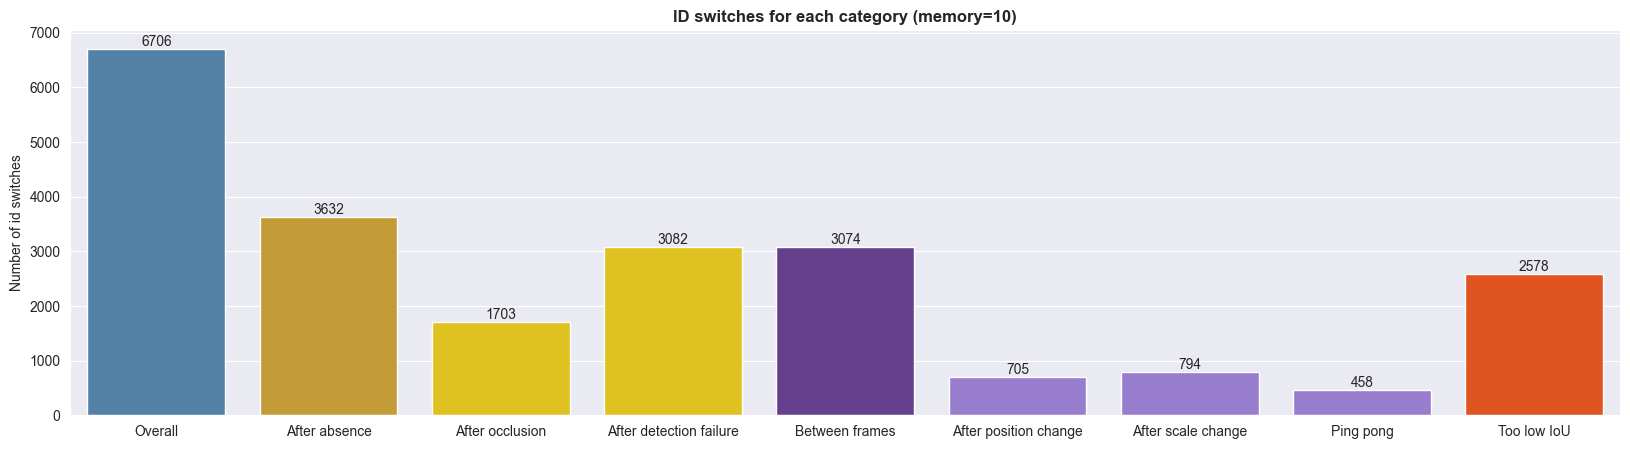

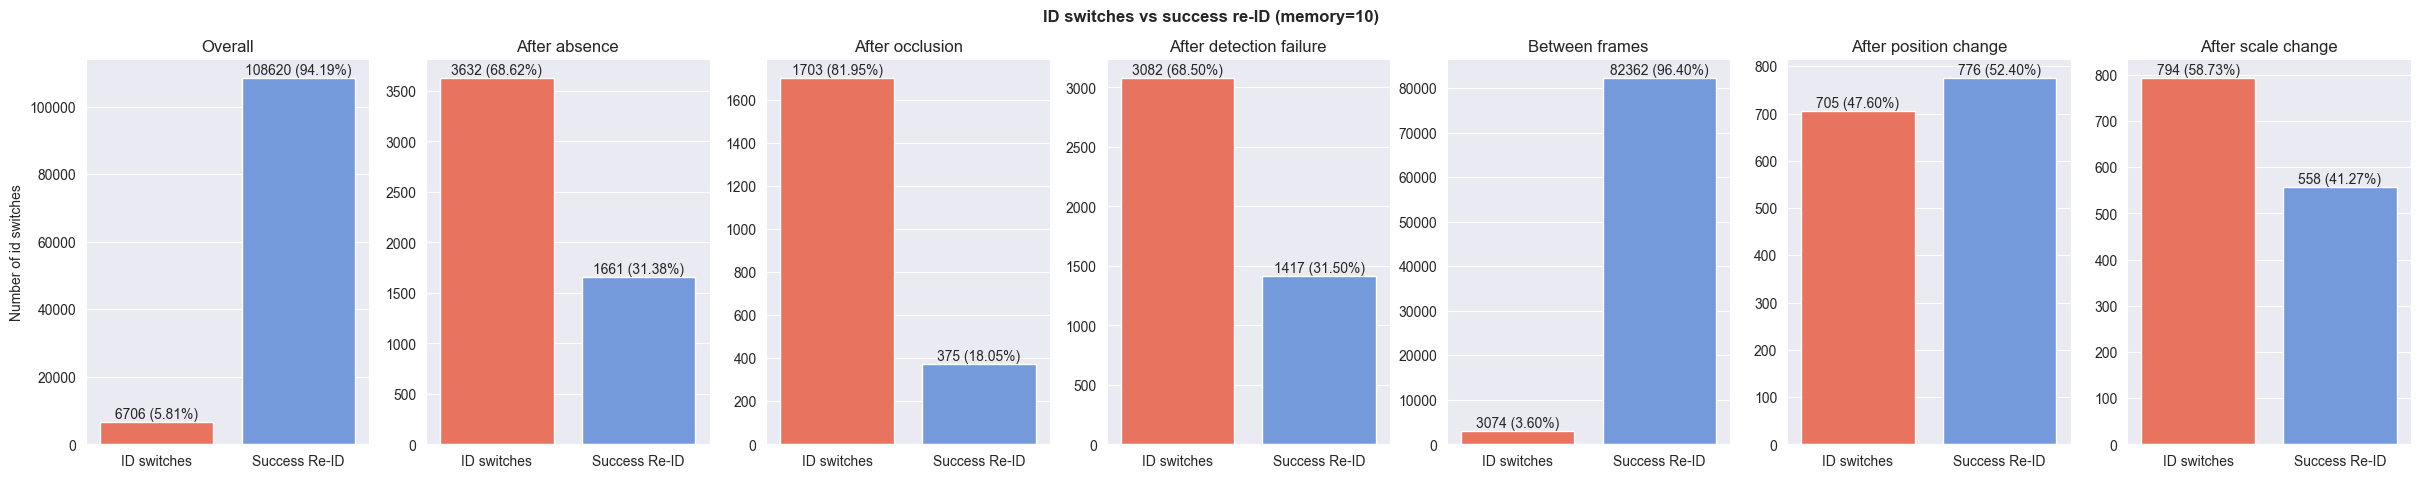

In [35]:

def showFailuresSuccesses(df):
    num_switches_overall = df["id_switch"].sum()
    possible_assoc_overall = df["possible_assosiations"].sum()
    num_success_overall = possible_assoc_overall - num_switches_overall

    num_switches_absence = df["id_switch_absence"].sum()
    possible_assoc_absence = df["possible_assosiations_absence"].sum()
    num_success_absence = possible_assoc_absence - num_switches_absence

    num_switches_occ = df["id_switch_occ"].sum()
    possible_assoc_occ = df["possible_assosiations_occ"].sum()
    num_success_occ = possible_assoc_occ - num_switches_occ

    num_switches_det = df["id_switch_det"].sum()
    possible_assoc_det = df["possible_assosiations_det"].sum()
    num_success_det = possible_assoc_det - num_switches_det

    num_switches_inter_frames = df["id_switch_inter_frames"].sum()
    possible_assoc_inter_frames = df["possible_assosiations_inter_frames"].sum()
    num_success_inter_frames = possible_assoc_inter_frames - num_switches_inter_frames

    num_switches_after_pos = df["id_switch_after_pos"].sum()
    possible_assoc_after_pos = df["possible_assosiations_pos_changes"].sum()
    num_success_after_pos = possible_assoc_after_pos - num_switches_after_pos

    num_switches_after_scale = df["id_switch_after_scale"].sum()
    possible_assoc_after_scale = df["possible_assosiations_scale_changes"].sum()
    num_success_after_scale = possible_assoc_after_scale - num_switches_after_scale

    num_switches_ping_pong = df["id_switch_ping_pong"].sum()

    num_switches_too_low_iou = df["id_switch_too_low_iou"].sum()

    # plot barplot with 7 bars (overall, after absence, after occlusion, after detection failure, between frames, after position change, after scale change)
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    sns.barplot(
        x=["Overall", "After absence", "After occlusion", "After detection failure", "Between frames", "After position change", "After scale change", "Ping pong", "Too low IoU"],
        y=[num_switches_overall, num_switches_absence, num_switches_occ, num_switches_det, num_switches_inter_frames, num_switches_after_pos, num_switches_after_scale, num_switches_ping_pong, num_switches_too_low_iou],
        palette=["steelblue", "goldenrod", "gold", "gold", "rebeccapurple", "mediumpurple", "mediumpurple", "mediumpurple", "orangered"]
    )
    for i, v in enumerate([num_switches_overall, num_switches_absence, num_switches_occ, num_switches_det, num_switches_inter_frames, num_switches_after_pos, num_switches_after_scale, num_switches_ping_pong, num_switches_too_low_iou]):
        ax.text(i, v + 1, f"{v}", ha='center', va='bottom')
    plt.ylabel("Number of id switches")
    plt.title(f"ID switches for each category (memory={memory_frames})", fontweight='bold')
    plt.show()



    # Plot failures vs success
    fig, ax = plt.subplots(1, 7, figsize=(30, 5))
    sns.barplot(x=["ID switches", "Success Re-ID"], y=[num_switches_overall, num_success_overall], ax=ax[0], palette=['tomato', 'cornflowerblue'])
    ax[0].set_ylabel("Number of id switches")
    ax[0].set_title("Overall")
    for i, v in enumerate([num_switches_overall, num_success_overall]):
        ax[0].text(i, v + 1, f"{v} ({v / possible_assoc_overall * 100:.2f}%)", ha='center', va='bottom')

    sns.barplot(x=["ID switches", "Success Re-ID"], y=[num_switches_absence, num_success_absence], ax=ax[1], palette=['tomato', 'cornflowerblue'])
    ax[1].set_title("After absence")
    for i, v in enumerate([num_switches_absence, num_success_absence]):
        ax[1].text(i, v + 1, f"{v} ({v / possible_assoc_absence * 100:.2f}%)", ha='center', va='bottom')

    sns.barplot(x=["ID switches", "Success Re-ID"], y=[num_switches_occ, num_success_occ], ax=ax[2], palette=['tomato', 'cornflowerblue'])
    ax[2].set_title("After occlusion")
    for i, v in enumerate([num_switches_occ, num_success_occ]):
        ax[2].text(i, v, f"{v} ({v / possible_assoc_occ * 100:.2f}%)", ha='center', va='bottom')

    sns.barplot(x=["ID switches", "Success Re-ID"], y=[num_switches_det, num_success_det], ax=ax[3], palette=['tomato', 'cornflowerblue'])
    ax[3].set_title("After detection failure")
    for i, v in enumerate([num_switches_det, num_success_det]):
        ax[3].text(i, v + 1, f"{v} ({v / possible_assoc_det * 100:.2f}%)", ha='center', va='bottom')

    sns.barplot(x=["ID switches", "Success Re-ID"], y=[num_switches_inter_frames, num_success_inter_frames], ax=ax[4], palette=['tomato', 'cornflowerblue'])
    ax[4].set_title("Between frames")
    for i, v in enumerate([num_switches_inter_frames, num_success_inter_frames]):
        ax[4].text(i, v + 1, f"{v} ({v / possible_assoc_inter_frames * 100:.2f}%)", ha='center', va='bottom')

    sns.barplot(x=["ID switches", "Success Re-ID"], y=[num_switches_after_pos, num_success_after_pos], ax=ax[5], palette=['tomato', 'cornflowerblue'])
    ax[5].set_title("After position change")
    for i, v in enumerate([num_switches_after_pos, num_success_after_pos]):
        ax[5].text(i, v + 1, f"{v} ({v / possible_assoc_after_pos * 100:.2f}%)", ha='center', va='bottom')

    sns.barplot(x=["ID switches", "Success Re-ID"], y=[num_switches_after_scale, num_success_after_scale], ax=ax[6], palette=['tomato', 'cornflowerblue'])
    ax[6].set_title("After scale change")
    for i, v in enumerate([num_switches_after_scale, num_success_after_scale]):
        ax[6].text(i, v + 1, f"{v} ({v / possible_assoc_after_scale * 100:.2f}%)", ha='center', va='bottom')

    plt.suptitle(f"ID switches vs success re-ID (memory={memory_frames})", fontweight='bold')
    plt.show()

showFailuresSuccesses(track_with_failures)


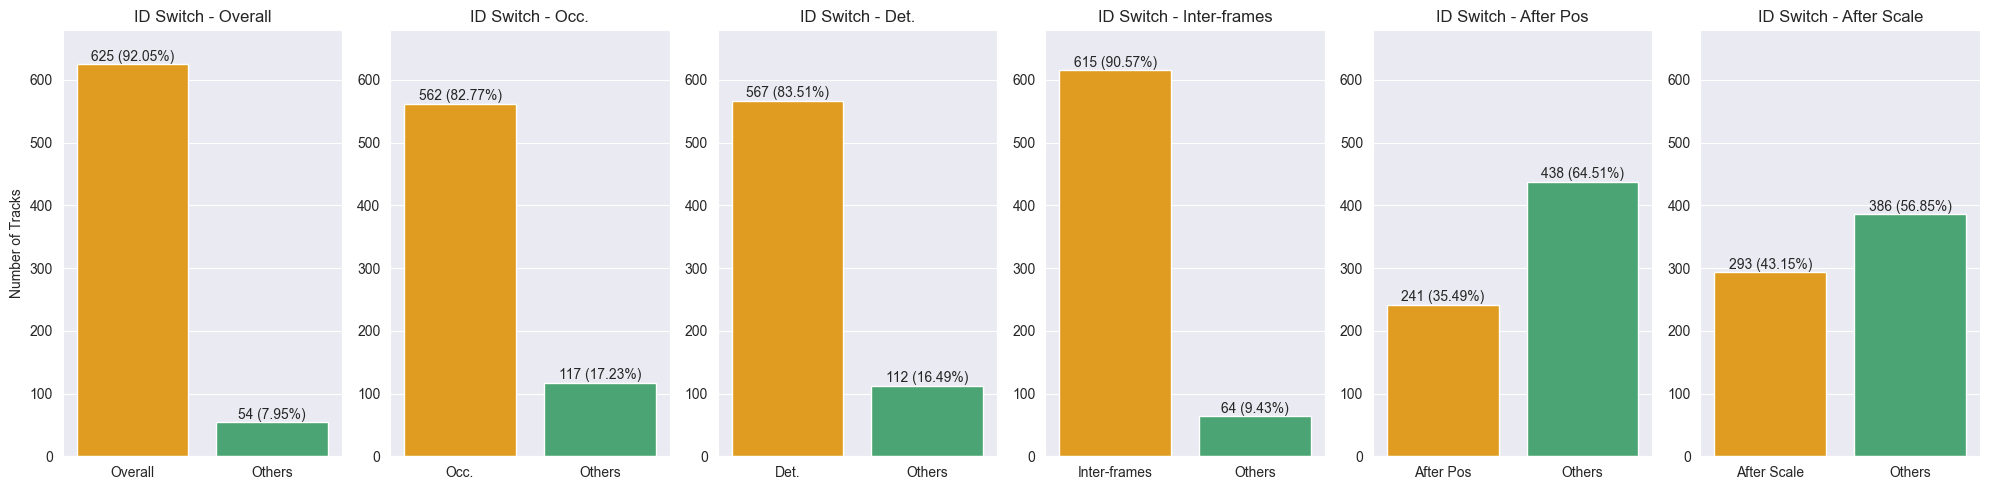

In [36]:
total_tracks = track_with_failures.shape[0]
num_tracks_with_id_switches = track_with_failures[track_with_failures["id_switch"] > 0].shape[0]
num_tracks_with_id_switches_occ = track_with_failures[track_with_failures["id_switch_occ"] > 0].shape[0]
num_tracks_with_id_switches_det = track_with_failures[track_with_failures["id_switch_det"] > 0].shape[0]
num_tracks_with_id_switches_inter_frames = track_with_failures[track_with_failures["id_switch_absence"] > 0].shape[0]
num_tracks_with_id_switches_after_pos = track_with_failures[track_with_failures["id_switch_after_pos"] > 0].shape[0]
num_tracks_with_id_switches_after_scale = track_with_failures[track_with_failures["id_switch_after_scale"] > 0].shape[0]


fig, ax = plt.subplots(1, 6, figsize=(20, 5))

# Plot each specific cause of ID switch
categories = [
    ("Overall", num_tracks_with_id_switches),
    ("Occ.", num_tracks_with_id_switches_occ),
    ("Det.", num_tracks_with_id_switches_det),
    ("Inter-frames", num_tracks_with_id_switches_inter_frames),
    ("After Pos", num_tracks_with_id_switches_after_pos),
    ("After Scale", num_tracks_with_id_switches_after_scale),
]

for idx, (label, value) in enumerate(categories):
    sns.barplot(x=[label, "Others"],
                y=[value, total_tracks - value],
                ax=ax[idx], palette=['orange', 'mediumseagreen'])
    ax[idx].set_ylabel("Number of Tracks") if idx == 0 else None
    ax[idx].set_title(f"ID Switch - {label}")
    ax[idx].set_ylim((0, total_tracks))
    for i, v in enumerate([value, total_tracks - value]):
        ax[idx].text(i, v + 1, f"{v} ({v / total_tracks * 100:.2f}%)", ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Absence

Percentage of id switches caused by absence: 54.16045332538025%


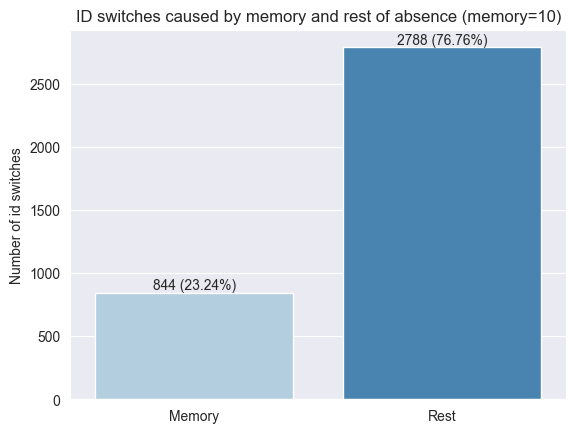

In [37]:
# print percentage of id switches caused by absence
num_switches_absence = track_with_failures["id_switch_absence"].sum()
num_id_switches = track_with_failures["id_switch"].sum()
print(f"Percentage of id switches caused by absence: {num_switches_absence / num_id_switches * 100}%")

# print barchart with 2 bars (id witches caused by memory, rest of absence caused id switches)
num_id_switch_mem = track_with_failures["id_switch_mem"].sum()
num_id_switch_absence = track_with_failures["id_switch_absence"].sum()
num_id_switch_rest = track_with_failures["id_switch_absence"].sum() - num_id_switch_mem
sns.barplot(x=["Memory", "Rest"], y=[num_id_switch_mem, num_id_switch_rest], palette="Blues")
plt.ylabel("Number of id switches")
plt.title(f"ID switches caused by memory and rest of absence (memory={memory_frames})")
# Add numbers on top of the bars with percentage
for i, v in enumerate([num_id_switch_mem, track_with_failures["id_switch_absence"].sum() - num_id_switch_mem]):
    plt.text(i, v + 1, f"{v} ({v / num_id_switch_absence * 100:.2f}%)", ha='center', va='bottom')
plt.show()

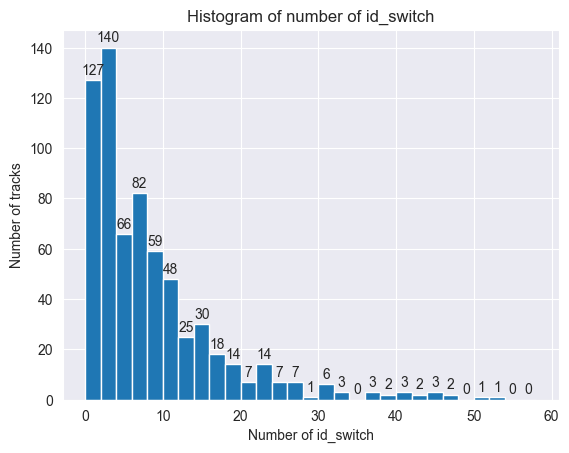

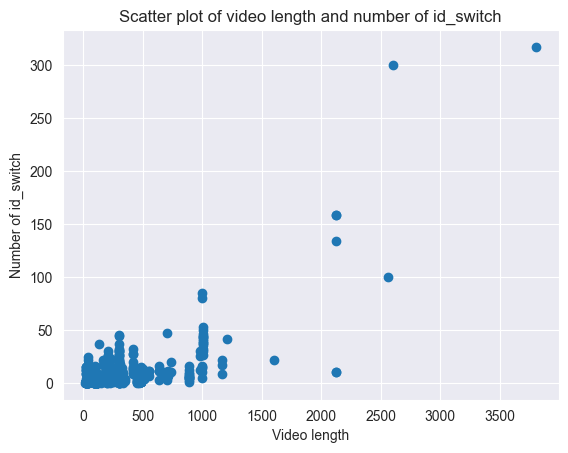

In [38]:
# Repeat this for each category
def showHistScatter(df, category):
    plt.hist(df[category], bins=range(0, 60, 2))
    plt.xlabel(f"Number of {category}")
    plt.ylabel("Number of tracks")
    plt.title(f"Histogram of number of {category}")
    for i, v in enumerate(np.histogram(df[category], bins=range(0, 60, 2))[0]):
        plt.text(2*i + 1, v + 1, f"{v}", ha='center', va='bottom')
    plt.show()

    plt.scatter(df["video_length"], df[category])
    plt.xlabel("Video length")
    plt.ylabel(f"Number of {category}")
    plt.title(f"Scatter plot of video length and number of {category}")
    plt.show()

showHistScatter(track_with_failures, "id_switch")
#showHistScatter(track_with_failures, "id_switch_absence")
#showHistScatter(track_with_failures, "id_switch_occ")
#showHistScatter(track_with_failures, "id_switch_det")
#showHistScatter(track_with_failures, "id_switch_inter_frames")
#showHistScatter(track_with_failures, "id_switch_after_pos")
#showHistScatter(track_with_failures, "id_switch_after_scale")
#showHistScatter(track_with_failures, "ping_pong_id_switches")

## Venn Diagram

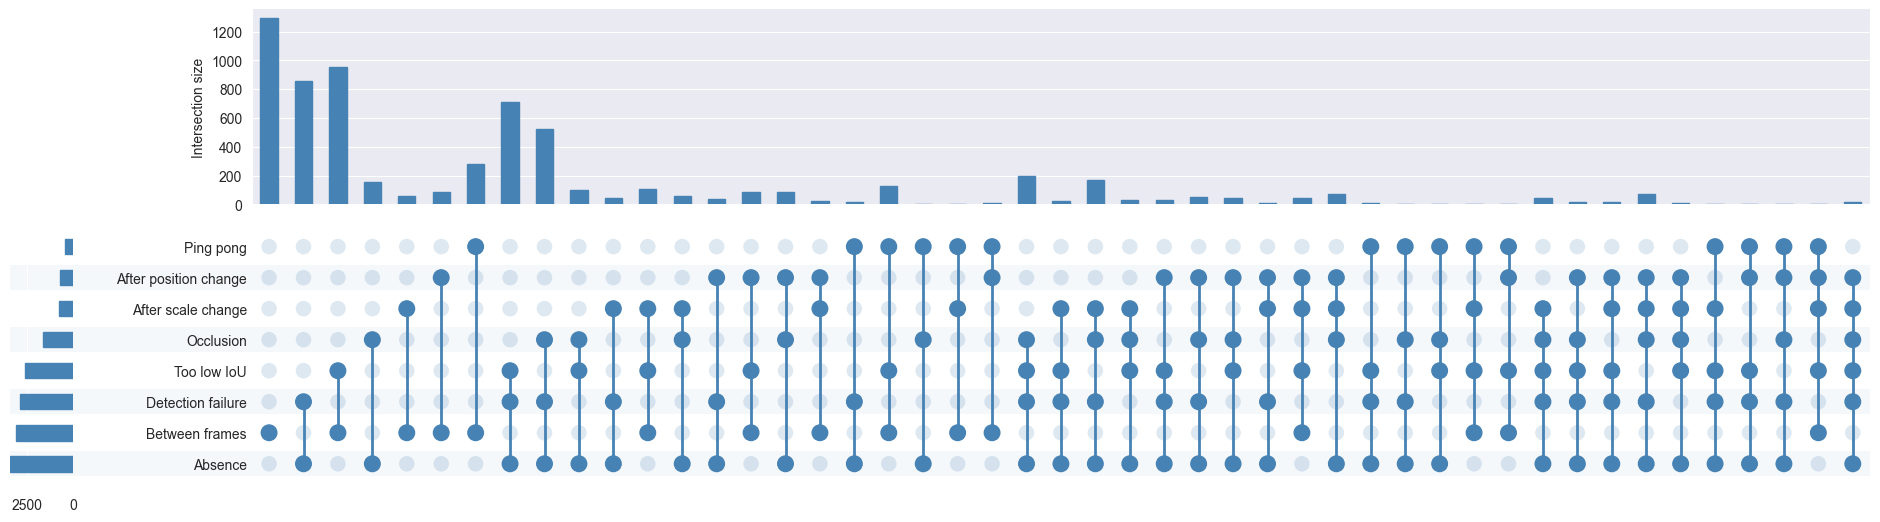

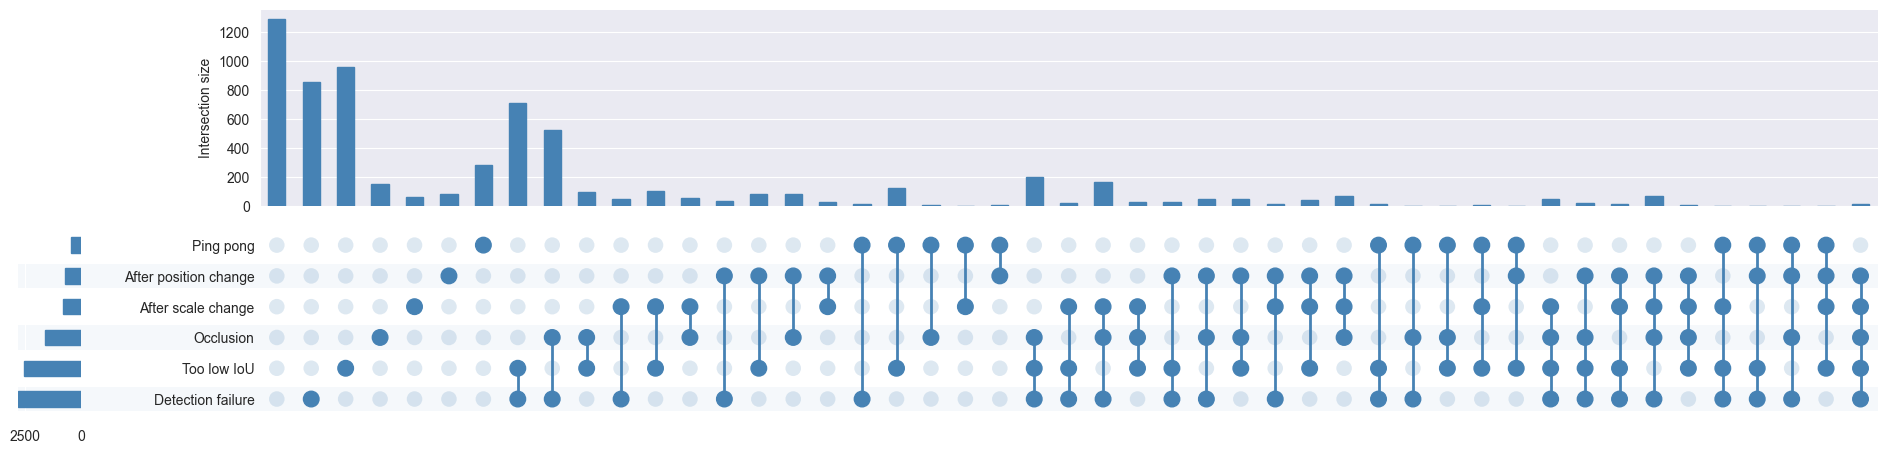

In [39]:
from upsetplot import UpSet, from_indicators

venn_df_renamed = venn_df.copy()

# rename columns
venn_df_renamed = venn_df_renamed.rename(columns={
    "is_switch_absence": "Absence",
    "is_switch_inter_frames": "Between frames",
    "is_switch_after_pos": "After position change",
    "is_switch_after_scale": "After scale change",
    "is_switch_occ": "Occlusion",
    "is_switch_det": "Detection failure",
    "is_switch_too_low_iou": "Too low IoU",
    "is_switch_ping_pong": "Ping pong"
})

upset_data = from_indicators(["Absence", "Occlusion", "Detection failure", "Between frames", "After position change", "After scale change", "Too low IoU", "Ping pong"], venn_df_renamed)

UpSet(upset_data, facecolor="steelblue").plot()
plt.show()

upset_data = from_indicators(["Occlusion", "Detection failure", "After position change", "After scale change", "Too low IoU", "Ping pong"], venn_df_renamed)

UpSet(upset_data, facecolor="steelblue").plot()
plt.show()

## Video Lists

In [40]:
all_videos = track_with_failures["video_name"].unique()
videos_with_id_switches = track_with_failures[track_with_failures["id_switch"] > 0]["video_name"].unique()
videos_with_id_switches_absence = track_with_failures[track_with_failures["id_switch_absence"] > 0]["video_name"].unique()
videos_with_id_switches_occ = track_with_failures[track_with_failures["id_switch_occ"] > 0]["video_name"].unique()
videos_with_id_switches_det = track_with_failures[track_with_failures["id_switch_det"] > 0]["video_name"].unique()
videos_with_id_switches_inter_frames = track_with_failures[track_with_failures["id_switch_inter_frames"] > 0]["video_name"].unique()
videos_with_id_switches_after_pos = track_with_failures[track_with_failures["id_switch_after_pos"] > 0]["video_name"].unique()
videos_with_id_switches_after_scale = track_with_failures[track_with_failures["id_switch_after_scale"] > 0]["video_name"].unique()
videos_with_id_switches_ping_pong = track_with_failures[track_with_failures["id_switch_ping_pong"] > 0]["video_name"].unique()
videos_with_id_switches_too_low_iou = track_with_failures[track_with_failures["id_switch_too_low_iou"] > 0]["video_name"].unique()

video_list = [videos_with_id_switches, videos_with_id_switches_absence, videos_with_id_switches_occ, videos_with_id_switches_det, videos_with_id_switches_inter_frames, videos_with_id_switches_after_pos, videos_with_id_switches_after_scale, videos_with_id_switches_ping_pong, videos_with_id_switches_too_low_iou]

# create set
video_set = set()
for videos in video_list:
    for video in videos:
        video_set.add(video)

print(f"Number of all videos: {len(all_videos)}")
print(f"Number of hard videos: {len(video_set)}")
print("Videos with id switches: ", len(videos_with_id_switches))
print("Videos with id switches caused by absence: ", len(videos_with_id_switches_absence))
print("Videos with id switches caused by occlusion: ", len(videos_with_id_switches_occ))
print("Videos with id switches caused by detection failure: ", len(videos_with_id_switches_det))
print("Videos with id switches caused by between frames: ", len(videos_with_id_switches_inter_frames))
print("Videos with id switches caused by position change: ", len(videos_with_id_switches_after_pos))
print("Videos with id switches caused by scale change: ", len(videos_with_id_switches_after_scale))
print("Videos with ping pong id switches: ", len(videos_with_id_switches_ping_pong))
print("Videos with id switches caused by too low IoU: ", len(videos_with_id_switches_too_low_iou))


video_list_names = ["id_switches", "id_switches_absence", "id_switches_occ", "id_switches_det", "id_switches_inter_frames", "id_switches_after_pos", "id_switches_after_scale", "id_switch_ping_pong", "id_switches_too_low_iou"]

# print it so that it can be copy pasted to python code
for name, v_list in zip(video_list_names, video_list):
    print(f"{name} = {list(v_list)[:5]}")


Number of all videos: 233
Number of hard videos: 214
Videos with id switches:  214
Videos with id switches caused by absence:  212
Videos with id switches caused by occlusion:  203
Videos with id switches caused by detection failure:  196
Videos with id switches caused by between frames:  170
Videos with id switches caused by position change:  135
Videos with id switches caused by scale change:  138
Videos with ping pong id switches:  80
Videos with id switches caused by too low IoU:  171
id_switches = ['TAO/YFCC100M/v_2dbe9f59c615e1641d42829f94607281', 'TAO/YFCC100M/v_bf3cad1558afc304c4d28a699c16de7', 'TAO/HACS/Camel_ride_v_FOlkdk4hiKY_scene_0_0-1071', 'TAO/HACS/Shaving_v_8AUE0UANshQ_scene_0_83-2198', 'TAO/HACS/Drum_corps_v_gY0MK_PAfps_scene_0_47-3186']
id_switches_absence = ['TAO/YFCC100M/v_2dbe9f59c615e1641d42829f94607281', 'TAO/YFCC100M/v_bf3cad1558afc304c4d28a699c16de7', 'TAO/HACS/Camel_ride_v_FOlkdk4hiKY_scene_0_0-1071', 'TAO/HACS/Shaving_v_8AUE0UANshQ_scene_0_83-2198', 'TAO/HACS

In [41]:
# for ech category show the top 5 videos with the most id switches as python code
for name, v_list in zip(video_list_names, video_list):
    videos = track_with_failures[track_with_failures["video_name"].isin(v_list)].groupby("video_name")["id_switch"].sum().sort_values(ascending=False).head(5)

    # print as python code
    print(f"{name} = {list(videos.index)}")


id_switches = ['DanceTrack/dancetrack0041', 'BDD/b1d22ed6-f1cac061', 'LaSOT/yoyo-7', 'OVT-B/AnimalTrack/goose_3', 'LaSOT/volleyball-18']
id_switches_absence = ['DanceTrack/dancetrack0041', 'BDD/b1d22ed6-f1cac061', 'LaSOT/yoyo-7', 'OVT-B/AnimalTrack/goose_3', 'LaSOT/volleyball-18']
id_switches_occ = ['DanceTrack/dancetrack0041', 'BDD/b1d22ed6-f1cac061', 'LaSOT/yoyo-7', 'OVT-B/AnimalTrack/goose_3', 'LaSOT/volleyball-18']
id_switches_det = ['DanceTrack/dancetrack0041', 'BDD/b1d22ed6-f1cac061', 'LaSOT/yoyo-7', 'OVT-B/AnimalTrack/goose_3', 'LaSOT/volleyball-18']
id_switches_inter_frames = ['DanceTrack/dancetrack0041', 'BDD/b1d22ed6-f1cac061', 'LaSOT/yoyo-7', 'OVT-B/AnimalTrack/goose_3', 'LaSOT/volleyball-18']
id_switches_after_pos = ['DanceTrack/dancetrack0041', 'BDD/b1d22ed6-f1cac061', 'LaSOT/yoyo-7', 'LaSOT/volleyball-18', 'OVT-B/OVIS/37af9ac1']
id_switches_after_scale = ['DanceTrack/dancetrack0041', 'BDD/b1d22ed6-f1cac061', 'LaSOT/yoyo-7', 'LaSOT/volleyball-18', 'OVT-B/OVIS/37af9ac1']
id

## Others

3                                      [5]
4                              [15, 19, 2]
5                               [1, 25, 3]
21                                    [18]
23                         [1, 3, 1, 1, 7]
                       ...                
1378                      [1, 1, 44, 2, 9]
1379                                  [68]
1382                      [12, 1, 1, 1, 1]
1383    [3, 5, 2, 1, 9, 2, 20, 1, 8, 2, 1]
1384                              [20, 14]
Name: id_switch_absence_lengths, Length: 679, dtype: object
[5, 15, 19, 2, 1, 25, 3, 18, 1, 3, 1, 1, 7, 28, 19, 1, 22, 3, 17, 23, 2, 3, 16, 1, 17, 16, 21, 1, 22, 3, 6, 7, 2, 15, 15, 16, 2, 5, 8, 1, 1, 3, 2, 16, 6, 5, 17, 1, 5, 17, 3, 5, 1, 1, 2, 1, 5, 2, 1, 5, 3, 10, 15, 2, 5, 4, 8, 2, 4, 1, 5, 1, 1, 2, 1, 1, 2, 22, 15, 1, 18, 6, 1, 7, 2, 14, 3, 2, 12, 19, 19, 4, 17, 2, 17, 3, 2, 2, 1, 5, 3, 10, 6, 1, 5, 4, 1, 6, 4, 2, 2, 7, 20, 2, 6, 1, 4, 8, 1, 3, 1, 5, 4, 21, 4, 2, 7, 8, 3, 23, 1, 8, 2, 23, 16, 18, 2, 19, 4, 21, 7, 3, 

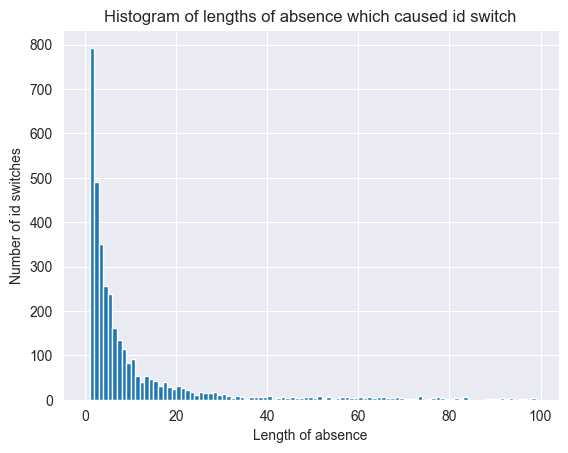

3             [8, 5, 2, 2, 2]
4                          []
5                          []
21                         []
23                        [2]
                ...          
1378       [1, 1, 5, 1, 4, 1]
1379                      [2]
1382    [2, 2, 2, 2, 2, 1, 1]
1383                   [1, 3]
1384                       []
Name: success_after_absence_lengths, Length: 679, dtype: object
[8, 5, 2, 2, 2, 2, 3, 1, 1, 2, 1, 9, 1, 2, 1, 5, 17, 1, 1, 3, 1, 2, 8, 1, 1, 1, 1, 9, 1, 2, 2, 1, 5, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 3, 3, 1, 1, 3, 1, 1, 10, 5, 4, 1, 2, 1, 2, 3, 2, 1, 2, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 4, 1, 2, 2, 1, 7, 2, 1, 2, 1, 3, 6, 2, 1, 2, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 1, 3, 2, 2, 6, 4, 2, 1, 1, 2, 3, 1, 3, 4, 3, 1, 1, 1, 4, 2, 3, 1, 3, 3, 6, 1, 1, 3, 2, 1, 3, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 5, 2, 1, 1, 1, 7, 3, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 6, 2, 1, 2, 3, 2, 2, 1, 4, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 

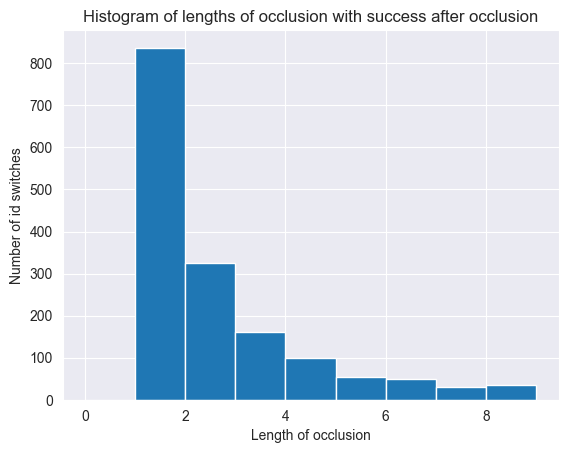

In [42]:
# histogram of lengths of absence which caused id switch
is_switch_absence_lengths = track_with_failures["id_switch_absence_lengths"]
print(is_switch_absence_lengths)
is_switch_absence_lengths = [length for lengths in is_switch_absence_lengths for length in lengths]
print(is_switch_absence_lengths, len(is_switch_absence_lengths))

plt.hist(is_switch_absence_lengths, bins=range(0, 100, 1))
plt.xlabel("Length of absence")
plt.ylabel("Number of id switches")
plt.title("Histogram of lengths of absence which caused id switch")
plt.show()

# histogram of lengths of absence with success after absence
success_after_absence_lengths = track_with_failures["success_after_absence_lengths"]
print(success_after_absence_lengths)
success_after_absence_lengths = [length for lengths in success_after_absence_lengths for length in lengths]
print(success_after_absence_lengths, len(success_after_absence_lengths))

plt.hist(success_after_absence_lengths, bins=range(0, 10, 1))
plt.xlabel("Length of occlusion")
plt.ylabel("Number of id switches")
plt.title("Histogram of lengths of occlusion with success after occlusion")
plt.show()


## Between frames

In [43]:
# Plot correlation between scale changes and id switches
plt.scatter(track_with_failures["scale_changes"], track_with_failures["id_switch"])
plt.xlabel("Number of scale changes")
plt.ylabel("Number of id switches")
plt.title("Correlation between scale changes and id switches")
plt.ylim(-1, 30)
plt.xlim(-1, 30)

# Calculate correlation
track_with_failures["scale_changes"] = pd.to_numeric(track_with_failures["scale_changes"], errors='coerce')
track_with_failures["id_switch"] = pd.to_numeric(track_with_failures["id_switch"], errors='coerce')
correlation = track_with_failures["scale_changes"].corr(track_with_failures["id_switch"])
print(f"Correlation between scale changes and id switches: {correlation}")

plt.show()

KeyError: 'scale_changes'